In [2]:
# Cell 1 – Imports & paths
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from pandas._typing import SequenceNotStr

ROOT     = Path("..").resolve()               # repo root
FIG_DIR  = ROOT / "reports" / "plots" / "hybrid"
ARTF     = ROOT / "artifacts" / "forecasts"
METR_DIR = ROOT / "artifacts" / "metrics"
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("Figures saved to:", FIG_DIR)


Figures saved to: /teamspace/studios/this_studio/AI_TimeSeries_Forecasting/reports/plots/hybrid


In [3]:
# Cell 2 – Load series & metrics
truth = pd.read_parquet("../data/processed/nasdaq_features.parquet")["log_ret"]
truth_test = truth.loc["2023-11-01":]       # matches hybrid range

fc_classical = pd.read_csv(ARTF/"arimax_test.csv", index_col=0, parse_dates=True).squeeze()
fc_dl        = pd.read_csv(ARTF/"lstm_test.csv",   index_col=0, parse_dates=True).squeeze()
fc_hybrid    = pd.read_csv(ARTF/"hybrid_test.csv", index_col=0, parse_dates=True).squeeze()

def metrics(y_true, y_pred):
    err = y_true - y_pred
    return {
        "MAE" : np.mean(np.abs(err)),
        "RMSE": np.sqrt(np.mean(err**2)),
        "MAPE": np.mean(np.abs(err / np.where(np.abs(y_true)<1e-8, 1e-8, y_true))) * 100
    }

metr_df = pd.DataFrame({
    "Classical" : metrics(truth.loc[fc_classical.index], fc_classical),
    "DL-LSTM"   : metrics(truth.loc[fc_dl.index],        fc_dl),
    "Hybrid"    : metrics(truth.loc[fc_hybrid.index],    fc_hybrid),
}).T.round(6)

display(metr_df)
metr_df.to_csv(METR_DIR/"hybrid_vs_baselines.csv")


,MAE,RMSE,MAPE
Classical,0.000838,0.000866,372619.109058
DL-LSTM,0.008275,0.011848,621714.753384
Hybrid,0.000834,0.000862,370727.883580


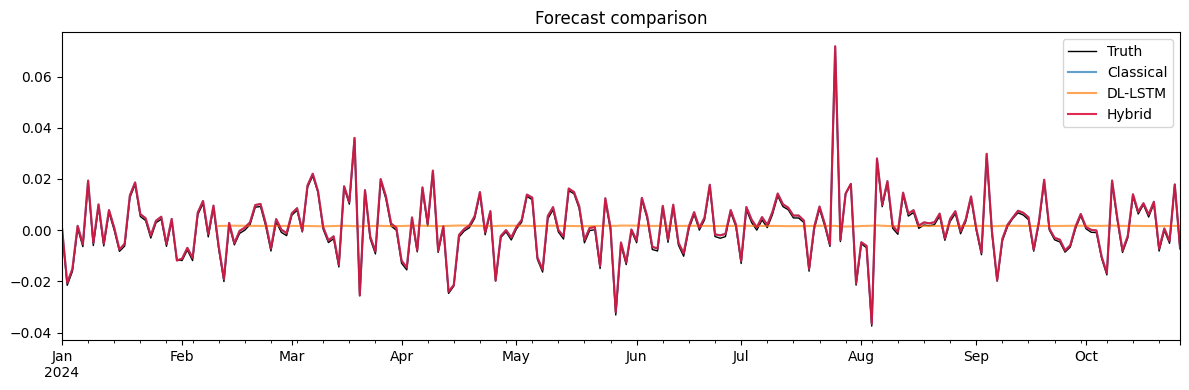

In [4]:
# Cell 3 – Overlay truth & forecasts
plt.figure(figsize=(12,4))
truth.loc[fc_hybrid.index].plot(label="Truth", lw=1, color="black")
fc_classical.plot(label="Classical", alpha=.7)
fc_dl.plot(label="DL-LSTM", alpha=.7)
fc_hybrid.plot(label="Hybrid", alpha=.9, color="crimson")
plt.title("Forecast comparison")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR/"forecast_overlay.png", dpi=300)
plt.show()


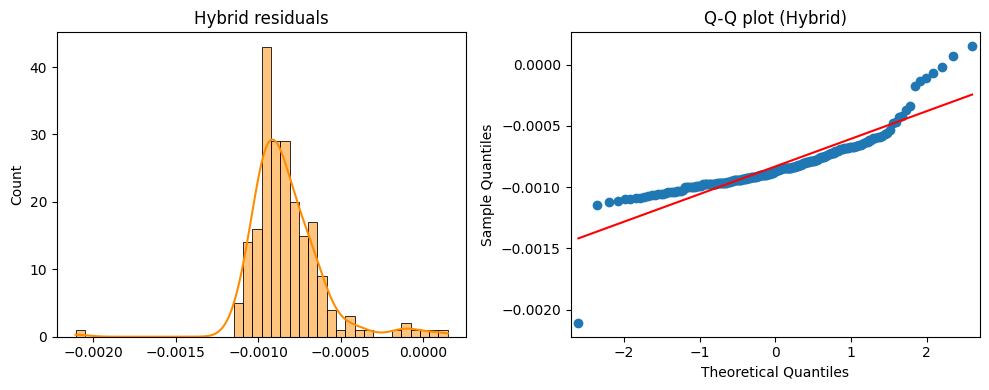

In [5]:
# Cell 4 – Hybrid residual diagnostics
res_hybrid = truth.loc[fc_hybrid.index] - fc_hybrid
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.histplot(res_hybrid, bins=40, kde=True, ax=ax[0], color="darkorange")
ax[0].set_title("Hybrid residuals")
qqplot(res_hybrid, line="s", ax=ax[1])
ax[1].set_title("Q-Q plot (Hybrid)")
fig.tight_layout()
fig.savefig(FIG_DIR/"hybrid_residuals.png", dpi=300)
plt.show()


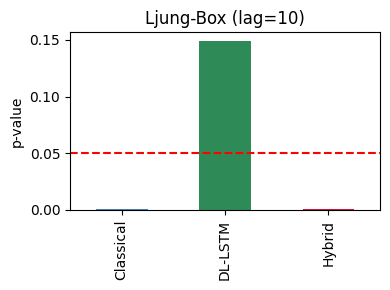

,LB p-value
Classical,0.00077
DL-LSTM,0.14925
Hybrid,0.00078


In [6]:
# Cell 5 – Ljung-Box p-values
def lb_p(series): return acorr_ljungbox(series, lags=[10], return_df=True)["lb_pvalue"].iloc[0]

pvals = {
    "Classical": lb_p(truth.loc[fc_classical.index] - fc_classical),
    "DL-LSTM"  : lb_p(truth.loc[fc_dl.index]        - fc_dl),
    "Hybrid"   : lb_p(res_hybrid)
}
p_ser = pd.Series(pvals)

plt.figure(figsize=(4,3))
p_ser.plot(kind="bar", color=["steelblue","seagreen","crimson"])
plt.axhline(0.05, ls="--", color="red")
plt.ylabel("p-value")
plt.title("Ljung-Box (lag=10)")
plt.tight_layout()
plt.savefig(FIG_DIR/"ljungbox_pvalues.png", dpi=300)
plt.show()

display(p_ser.to_frame("LB p-value").round(5))


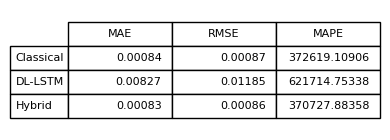

In [7]:
# Cell 6 – Save metrics table as PNG
fig, ax = plt.subplots(figsize=(4,1.5))
ax.axis("off")
tbl = ax.table(cellText=metr_df.values.round(5),
               rowLabels=metr_df.index,
               colLabels=metr_df.columns,
               loc="center")
tbl.auto_set_font_size(False); tbl.set_fontsize(8)
tbl.scale(1,1.4)
plt.tight_layout()
plt.savefig(FIG_DIR/"metrics_table.png", dpi=300)
plt.show()


In [8]:
# Cell 7 – Summary
print("Hybrid-model evaluation complete.\n",
      "Plots saved to:", FIG_DIR,
      "\nMetrics CSV :", METR_DIR/"hybrid_vs_baselines.csv")


Hybrid-model evaluation complete.
 Plots saved to: /teamspace/studios/this_studio/AI_TimeSeries_Forecasting/reports/plots/hybrid 
Metrics CSV : /teamspace/studios/this_studio/AI_TimeSeries_Forecasting/artifacts/metrics/hybrid_vs_baselines.csv
